# Create Motor Imagery Decoder
Use this clean notebook to create the decoder that will classify future motor imagery data. Please see `Exploration_Enobio_Motor_Screening.ipnyb` for the full exploration.

Nile Wilson 2019.01.16

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data

import scipy.signal as scisig
import numpy as np
import pandas as pd
import datetime
import pickle
import csv
import mne

## Function Definitions

In [2]:
def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

In [3]:
def LoadBehavioralData(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    behavioralData = behavioralData.transpose()
    behavioralHeader = behavioralData.iloc[0]
    behavioralData = behavioralData.iloc[2:]
    behavioralData.columns = behavioralHeader
    
    return behavioralData

In [4]:
def SyncTriggerPulses(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        # Store where the values in trigger are equal to 8 (the audio trigger input channel number)
        index_trigger = np.where(EEGdata['STI 014']!=0)
        index_trigger = index_trigger[0]
        
        # Check number of trials
        num_of_trials = behavioralData.shape[0]
        if num_of_trials > len(index_trigger):
            num_of_trials = num_of_trials - 1
            num_trials_removed = 1
        else:
            num_trials_removed = 0
        
        trialLength = int(behavioralData['trialLength'][0])

        # Get trial timing
        t_trial_start = list()
        t_trial_end = list()

        # Creating lists of all trigger start and end locations
        for i in range(0,num_of_trials):
            t_trial_start.append(index_trigger[i])
            t_trial_end.append(index_trigger[i] + int(trialLength*fs))

        # Save rest period epochs as well as trials for comparison
        t_rest_start = list()
        t_rest_end = list()

        for i in range(num_of_trials-1):
            t_rest_start.append(t_trial_end[i])
            t_rest_end.append(t_trial_start[i+1])
    
    return num_of_trials, t_trial_start, t_trial_end, t_rest_start, t_rest_end

In [5]:
def EpochData(EEGdata, t_trial_start, t_trial_end):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]
    
    epochs = []
    epochs_norm = []

    for trial in range(0,len(t_trial_start)):
        t_start = t_trial_start[trial]
        t_end = t_trial_end[trial]

        # Baseline
        if trial == 0:
            tb_start = t_trial_start[trial] - np.round(1.5*fs)
            tb_end = t_trial_start[trial]
        else:
            tb_start = t_trial_end[trial-1]
            tb_end = t_trial_start[trial]
            
        baseline = EEGdata.loc[tb_start:tb_end][channels]
        
        # Store epoch
        tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
        epochs_norm.append(tmp)
        epochs.append(EEGdata.loc[t_start:t_end][channels])
    
    return epochs, epochs_norm

In [6]:
def CutEpochs(epochs, fs, trial_type):
    epochs_cut = []
    trial_type_cut = list()

    num_of_epochs = len(epochs)
    full_epoch_length = np.shape(epochs[0])[0]
    cut_epoch_length = int(1.750*fs)

    sliding_window_starts = np.floor(np.linspace(1*fs, full_epoch_length - cut_epoch_length, 10))

    # For each epoch
    for epochOfInt in range(0,num_of_epochs):
        # Reset the index within each epoch temporarily
        reset_index = epochs[epochOfInt].reset_index(drop=True)

        # Sliding window of 750 ms
        for new_start in sliding_window_starts:
            tmp = reset_index.loc[new_start:new_start+cut_epoch_length]
            epochs_cut.append(tmp)
            trial_type_cut.append(trial_type[epochOfInt])
    
    num_of_trials_cut = len(trial_type_cut)
    
    return epochs_cut, trial_type_cut, num_of_trials_cut

In [7]:
def OrganizeTrials(behavioralData):
    """
    Organizes trials
    """
    
    # Create lists for each trial type
    trialL = list()
    trialR = list()
    i = 0

    for letter in behavioralData['trialType']:
        if letter == 'L':
            trialL.append(i)
        elif letter == 'R':
            trialR.append(i)
        i += 1
    
    # Create a single list that includes which trial is which (L = 0, R = 1)
    trial_type = list()
    i = 0

    for letter in behavioralData['trialType']:
        if letter == 'L':
            trial_type.append(0)
        elif letter == 'R':
            trial_type.append(1)
        i += 1

    return trial_type, trialL, trialR

In [8]:
def ExtractFeatures(epochs, num_of_trials, channelsToUse, ds_factor):
    """
    Extract signal features of interest
    """
    
    # Get the summed delta power for each trial
    alpha_power = dict.fromkeys(channelsToUse)
    beta_power = dict.fromkeys(channelsToUse)
    ds_f = ds_factor # downsampling factor

    for chanOfInt in channelsToUse:
        tmp_alpha = list()
        tmp_beta = list()

        for trial in range(0, num_of_trials):
            f, Pxx_den = signal.welch(signal.decimate(epochs[trial][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
            alpha_idx = np.where(np.logical_and(np.round(f) > 8, np.round(f) <= 12))
            tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))

            beta_idx = np.where(np.logical_and(np.round(f) > 13, np.round(f) <= 30))
            tmp_beta.append(np.sum(Pxx_den[beta_idx]))

        alpha_power[chanOfInt] = tmp_alpha
        beta_power[chanOfInt] = tmp_beta
    
    return alpha_power, beta_power

In [28]:
def TrainDecoder(X, y):
    """
    Trains the decoder on ALL the data (does not split into test and train because this is all train)
    """
    # preprocess dataset, split into training and test part
    args = np.arange(len(X))
    np.random.shuffle(args)
    X = [X[i] for i in args]
    y = [y[i] for i in args]
    X_not_scaled = X
    X = StandardScaler().fit_transform(X)
    

    # Determine model parameters
    activations = ['relu','tanh']
    alphas = np.logspace(-6, 3, 10)
    solvers = ['lbfgs','sgd']
    hyper_params = {"activation":activations, "alpha":alphas, "solver":solvers}
    grid = GridSearchCV(MLPClassifier(learning_rate='constant', random_state=1), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)
    grid.fit(X, y)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X,y)
    
    """
    # Split into train and test for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    grid.fit(X_train, y_train)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    print(grid.best_estimator_)
    print('-----------')
    print('score: ' + str(score))
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('-----------')
    """
    
    return clf, X, X_not_scaled, y

In [29]:
def SaveDecoderAndData(clf, X, X_not_scaled, y, subjID):
    """
    Save the decoder and the data it was trained/tested on
    """
    time_to_save = datetime.datetime.now().isoformat()
    time_to_save = time_to_save.replace('T','-')
    time_to_save = time_to_save.replace(':','-')
    
    model = clf
    model_file = 'Models/' + subjID + '_MI_classifier_' + time_to_save[:19] + '.sav'
    pickle.dump(model, open(model_file, 'wb'))
    
    filepath_export_data = 'Models/' + subjID + '_data_for_MI_classifier_' + time_to_save[:19] + '.npz'
    np.savez_compressed(filepath_export_data, X=X, X_not_scaled=X_not_scaled, y=y)

## Variables to Set

In [11]:
subjID = 'nile'
EEGdevice = 8 # 7 for DSI-7, 8 for Enobio
filename_eeg = 'SaveData/20190130121649_nile_Motor_Screening.easy'
filename_behavioral = 'SaveData/nile_Motor_Screening_R1.csv'

## Code to Run

### Run automatically

In [12]:
# Load EEG data
EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)

# Load behavioral data
behavioralData = LoadBehavioralData(filename_behavioral)

# Sync up trigger pulses
num_of_trials, t_trial_start, t_trial_end, t_rest_start, t_rest_end = SyncTriggerPulses(EEGdata, EEGdevice, fs, behavioralData)

# Clean the data
EEGdata_orig = EEGdata.copy()
lf = 1
hf = 40

if EEGdevice == 7:
    channels = EEGdata.columns[1:8]
elif EEGdevice == 8:
    channels = EEGdata.columns[0:8]

# Format our data into an mne-friendly format
ch_types = ['eeg']*len(channels)
info = mne.create_info(ch_names=list(channels), sfreq=fs, ch_types=ch_types)
rawData = EEGdata[channels].values
rawData = np.transpose(rawData)
raw = mne.io.array.RawArray(rawData, info)
raw.set_montage(mne.channels.read_montage(kind='standard_1020'))
raw.filter(l_freq=lf, h_freq=hf)

# Make a copy of the original data just in case
EEGdata[channels] = raw.get_data().T

# Epoch the data
epochs, epochs_norm = EpochData(EEGdata, t_trial_start, t_trial_end)

# Organize trial types
trial_type, trialL, trialR = OrganizeTrials(behavioralData)

# Cut epochs into 750 ms chunks
epochs_cut, trial_type_cut, num_of_trials_cut = CutEpochs(epochs_norm, fs, trial_type)

# Get signal features
alpha_power, beta_power = ExtractFeatures(epochs_cut, num_of_trials_cut, ['C3','C4'], 1)
motor_features = [alpha_power['C3'], alpha_power['C4'], beta_power['C3'], beta_power['C4']]
motor_features = np.transpose(motor_features)

Skipping N/A
Creating RawArray with float64 data, n_channels=7, n_times=299066
    Range : 0 ... 299065 =      0.000 ...   598.130 secs
Ready.
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


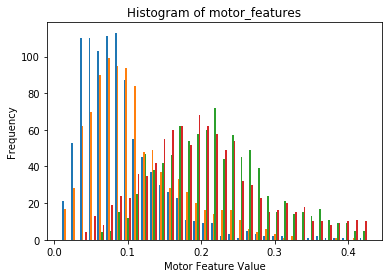

Each color is a different feature (alpha and beta power for C3 and C4)


In [13]:
plt.figure()
plt.hist(motor_features, bins='auto')
plt.xlabel('Motor Feature Value')
plt.ylabel('Frequency')
plt.title('Histogram of motor_features')
plt.show()
print('Each color is a different feature (alpha and beta power for C3 and C4)')

In [14]:
motor_features

array([[0.1172061 , 0.26986735, 0.29361296, 0.54411065],
       [0.10873798, 0.27677116, 0.30807692, 0.54805438],
       [0.1082541 , 0.25327512, 0.26539241, 0.44795396],
       ...,
       [0.03504125, 0.08010745, 0.12194143, 0.12499475],
       [0.03020208, 0.05099684, 0.11873638, 0.12420641],
       [0.03987682, 0.05767268, 0.1241643 , 0.13818258]])

In [15]:
StandardScaler().fit_transform(motor_features)

array([[ 0.47007737,  2.01526324,  0.5503876 ,  3.60414573],
       [ 0.31851625,  2.10394163,  0.68890108,  3.6470041 ],
       [ 0.30985581,  1.80213863,  0.2801347 ,  2.55916395],
       ...,
       [-1.0004979 , -0.42217346, -1.09361754, -0.95059158],
       [-1.08710856, -0.79609472, -1.12431054, -0.95915885],
       [-0.91395145, -0.7103446 , -1.07233025, -0.80727294]])

## Mess around with decoder

In [16]:
args = np.arange(len(motor_features))
np.random.shuffle(args)
X = [motor_features[i] for i in args]
y = [trial_type_cut[i] for i in args]
X = StandardScaler().fit_transform(X)

In [17]:
# Parameter tuning for SVM
Cs = [0.001, 0.01, 0.1, 1, 1.5, 2, 5]
degrees = [1, 2, 3, 4, 5]
hyper_params = {"C":Cs, "degree":degrees}
grid = GridSearchCV(SVC(kernel='rbf', gamma='auto'), param_grid=hyper_params, cv=KFold(n_splits=50), verbose=True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Fit
grid.fit(X_train, y_train)
grid.best_estimator_

# Score
svc = grid.best_estimator_
svc.fit(X_train, y_train)

Fitting 50 folds for each of 35 candidates, totalling 1750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1750 out of 1750 | elapsed:   26.2s finished
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
print('train score: ' + str(svc.score(X_train, y_train)))
print('test score: ' + str(svc.score(X_test, y_test)))
print(confusion_matrix(y_test, svc.predict(X_test)))

train score: 0.7388167388167388
test score: 0.696969696969697
[[ 93  62]
 [ 28 114]]


Let's try a linear kernel

In [20]:
# Parameter tuning for SVM
Cs = [0.001, 0.01, 0.1, 1, 1.5, 2, 5]
degrees = [1, 2, 3, 4, 5]
hyper_params = {"C":Cs, "degree":degrees}
grid = GridSearchCV(SVC(kernel='linear', gamma='auto'), param_grid=hyper_params, cv=KFold(n_splits=50), verbose=True)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Fit
grid.fit(X_train, y_train)
grid.best_estimator_

# Score
svc = grid.best_estimator_
svc.fit(X_train, y_train)

Fitting 50 folds for each of 35 candidates, totalling 1750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1750 out of 1750 | elapsed:   17.1s finished
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
print('train score: ' + str(svc.score(X_train, y_train)))
print('test score: ' + str(svc.score(X_test, y_test)))
print(confusion_matrix(y_test, svc.predict(X_test)))

train score: 0.6046176046176046
test score: 0.5791245791245792
[[ 70  96]
 [ 29 102]]


### Okay let's try the neural net again

In [23]:
args = np.arange(len(motor_features))
np.random.shuffle(args)
X = [motor_features[i] for i in args]
y = [trial_type_cut[i] for i in args]
X = StandardScaler().fit_transform(X)

# Determine model parameters
activations = ['relu','tanh']
alphas = np.logspace(-6, 3, 10)
solvers = ['lbfgs','sgd']
hyper_params = {"activation":activations, "alpha":alphas, "solver":solvers}
grid = GridSearchCV(MLPClassifier(learning_rate='constant', random_state=1), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)

# Split into train and test for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
grid.fit(X_train, y_train)

# Fit the model
clf = grid.best_estimator_
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic O

In [24]:
print(grid.best_estimator_)
print('-----------')
print('score: ' + str(score))
print(confusion_matrix(y_test, clf.predict(X_test)))
print('-----------')

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
-----------
score: 0.7474747474747475
[[110  40]
 [ 35 112]]
-----------


## Okay can now automate train

In [ ]:
# Train model
clf, X, X_not_scaled, y = TrainDecoder(motor_features, trial_type_cut)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [26]:
# Save decoder and data it was trained/tested on
SaveDecoderAndData(clf, X, X_not_scaled, y, subjID)